In [1]:
''' basic package '''
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

'''pytorch package'''
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

# 導入Dataset

In [4]:
# 導入MNIST 手寫數字集
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor())

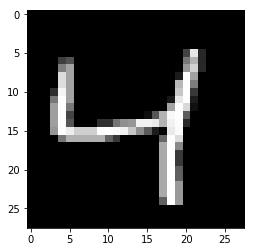

In [64]:
plt.imshow(train_dataset[2][0].numpy().reshape(28,28), cmap='gray')

In [8]:
# 將資料建成data loader 讀入
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定義RNN Model

In [14]:
# 定義 Recurrent Network 模型
class Rnn(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer, n_class):
        super(Rnn, self).__init__()
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, n_class)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] #[1,28,128] -> [1,128] 中間的-1表示取最後一筆運算結果
        out = self.classifier(out)
        return out

# 建立模型

In [3]:
# 定義超参数
batch_size = 100
learning_rate = 1e-3
num_epoches = 10

In [43]:
model = Rnn(28, 128, 2, 10)  # 圖片大小是28x28
use_gpu = torch.cuda.is_available()  # 判斷是否有GPU
if use_gpu:
    model = model.cuda()
    
# 定義loss function和optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
print(model)

Rnn(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [44]:
# 開始訓練
for epoch in range(num_epoches):
    
    print('epoch {}'.format(epoch + 1))
    print('*' * 10)
    
    running_loss = 0.0
    running_acc = 0.0
    
    eval_loss = 0.0
    eval_acc = 0.0
    
    for i, data in enumerate(train_loader, 1):        
        img, label = data      
        img = img.view(-1,28,28) #將圖片維度轉成28*28
        
        if use_gpu: #將tensor 轉成gpu tensor
            img = img.cuda()
            label = label.cuda()
            
        # 前向傳撥
        out = model(img)
        loss = criterion(out, label)
        running_loss += loss.item() * label.size(0) #計算loss
        
        _, pred = torch.max(out, 1) #判斷class
        num_correct = (pred == label).sum() #準確度
        running_acc += num_correct.item()
        
        # 後向傳撥
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 300 == 0:
            print('[{}/{}] Loss: {:.6f}, Acc: {:.6f}'.format(
                epoch + 1, num_epoches, running_loss / (batch_size * i),
                running_acc / (batch_size * i)))
            
    print('Finish {} epoch, Loss: {:.6f}, Acc: {:.6f}'.format(
        epoch + 1, running_loss / (len(train_dataset)), 
        running_acc / (len(train_dataset))))
    
    # 模型驗證
    for data in test_loader:        
        img, label = data
        img = img.view(-1,28,28)

        if use_gpu:
            img = img.cuda()
            label = label.cuda()
            
        out = model(img)
        loss = criterion(out, label)
        
        eval_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
        
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
        test_dataset)), eval_acc / (len(test_dataset))))
    print()

epoch 1
**********
[1/10] Loss: 0.737378, Acc: 0.752133
[1/10] Loss: 0.472883, Acc: 0.845050
Finish 1 epoch, Loss: 0.472883, Acc: 0.845050
Test Loss: 0.169459, Acc: 0.949200

epoch 2
**********
[2/10] Loss: 0.135623, Acc: 0.959133
[2/10] Loss: 0.122683, Acc: 0.963000
Finish 2 epoch, Loss: 0.122683, Acc: 0.963000
Test Loss: 0.085140, Acc: 0.975600

epoch 3
**********
[3/10] Loss: 0.086855, Acc: 0.972600
[3/10] Loss: 0.079127, Acc: 0.975433
Finish 3 epoch, Loss: 0.079127, Acc: 0.975433
Test Loss: 0.070094, Acc: 0.977800

epoch 4
**********
[4/10] Loss: 0.057382, Acc: 0.981633
[4/10] Loss: 0.057273, Acc: 0.982067
Finish 4 epoch, Loss: 0.057273, Acc: 0.982067
Test Loss: 0.058792, Acc: 0.982100

epoch 5
**********
[5/10] Loss: 0.045854, Acc: 0.985600
[5/10] Loss: 0.047466, Acc: 0.985267
Finish 5 epoch, Loss: 0.047466, Acc: 0.985267
Test Loss: 0.052235, Acc: 0.984200

epoch 6
**********
[6/10] Loss: 0.039250, Acc: 0.987867
[6/10] Loss: 0.042130, Acc: 0.986667
Finish 6 epoch, Loss: 0.042130, 

# 模型保存

In [45]:
# 保存模型
torch.save(model.state_dict(), './rnn.pth')

# 讀取模型和預測

In [55]:
model2 = Rnn(28, 128, 2, 10).cuda()

In [52]:
model2 = model2.load_state_dict(torch.load('./rnn.pth'))

In [58]:
out = model2(train_dataset[0][0].cuda())

In [62]:
torch.max(out, 1)[1]

tensor([ 2], device='cuda:0')